In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')

In [2]:
stock_symbol = 'BTC-USD' # Stock Symbol Google / Alphabet
# last 5 years data with interval 1 day
data = yf.download(tickers=stock_symbol, period='2y', interval='1h')
s = pd.Series(list(range(0, len(data))))
data.set_index(s, inplace=True)
data.head()
print(tf.config.experimental.list_physical_devices())
print(tf.__version__)
print(np.__version__)

[*********************100%***********************]  1 of 1 completed
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
2.6.0
1.19.5


In [3]:
data_training_size = int(len(data)*0.8)
data_test_size = len(data) - data_training_size
data_training, data_test = data.iloc[0:data_training_size,:], data.iloc[data_training_size:len(data),:]
data_training = data_training.drop(['Adj Close'], axis=1)
data_test = data_test.drop(['Adj Close'], axis=1)
data_training.head()

,Open,High,Low,Close,Volume
0,8503.509766,8513.885742,8471.529297,8482.250977,0
1,8482.747070,8482.747070,8419.917969,8425.261719,665116672
2,8428.125000,8428.125000,8273.573242,8300.673828,1515845632
3,8302.836914,8328.875000,8296.156250,8318.561523,538664960
4,8315.938477,8316.958008,8273.586914,8292.289062,0


In [4]:
sc = MinMaxScaler()
training_data = sc.fit_transform(data_training)
training_data

array([[6.70441786e-02, 6.38297185e-02, 7.23349624e-02, 6.69038225e-02,
        0.00000000e+00],
       [6.66993053e-02, 6.33123892e-02, 7.14795925e-02, 6.59572935e-02,
        4.71662882e-07],
       [6.57920198e-02, 6.24049132e-02, 6.90541776e-02, 6.38880254e-02,
        1.07495143e-06],
       ...,
       [4.85868083e-01, 4.82825854e-01, 4.87929358e-01, 4.84367990e-01,
        0.00000000e+00],
       [4.84174033e-01, 4.80874780e-01, 4.79463964e-01, 4.79517282e-01,
        0.00000000e+00],
       [4.79007601e-01, 4.80015344e-01, 4.77679809e-01, 4.73059338e-01,
        0.00000000e+00]])

In [5]:
window = 60# check that window is less than shape[0]
x_train = []
y_train = []
for i in range(window, training_data.shape[0]):
    # take from current minus 60 first dimension, empty seconds dimension to grab all 5
    x_train.append(training_data[i-window:i])
    y_train.append(training_data[i, 0]) # zero second dimension only to grab which result should be
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape, y_train.shape

((13629, 60, 5), (13629,))

In [6]:
model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(x_train.shape[1], 5)),
    keras.layers.Bidirectional(
        keras.layers.LSTM(units=80, activation='relu', return_sequences=True),
    ),
    keras.layers.Dropout(0.2),
    keras.layers.Bidirectional(
        keras.layers.LSTM(units=80, activation='relu', return_sequences=True),
    ),
    keras.layers.Dropout(0.3),
    keras.layers.Bidirectional(
        keras.layers.LSTM(units=80, activation='relu', return_sequences=True),
    ),
    keras.layers.Dropout(0.4),
    # the last one never must have return sequences true, bc you dont want your input to be the output
    # you want only a result
    keras.layers.Bidirectional(
        keras.layers.LSTM(units=120, activation='relu'),
    ),
    keras.layers.Dropout(0.5),
    # output layer, dense layer, return one result -> units
    keras.layers.Dense(units=1)
])
model.summary()

2021-11-18 13:51:13.001823: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 60, 160)           55040     
_________________________________________________________________
dropout (Dropout)            (None, 60, 160)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 60, 160)           154240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 160)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 60, 160)           154240    
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 160)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 240)               2

In [7]:
model.compile(
    optimizer='adam', #already does a batch aproach, re listen the podcast to remember later
    # adam algorithm is stochastic gradient decent, using batch but different from SGD uses adam algorithm to optimize
    loss = 'mean_squared_error'
)
model.fit(x_train, y_train, epochs=2, batch_size=32)

Epoch 1/2


2021-11-18 13:51:13.386687: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


426/426 [==============================] - 75s 168ms/step - loss: 0.0046
Epoch 2/2
426/426 [==============================] - 70s 164ms/step - loss: 0.0022


In [8]:
past_window_days = data_training.tail(window)
# get window size of previous data to continue from the training data to the test data
# that way we put a link between test and time line data

df = past_window_days.append(data_test, ignore_index = True)

In [9]:
inputs = sc.transform(df) # we transfor the data into an array and then gather the window sizes with the prediction

x_test = []
y_test = []
for i in range(window, inputs.shape[0]):
    # take from current minus 60 first dimension, empty seconds dimension to grab all 5
    x_test.append(inputs[i-window:i])
    y_test.append(inputs[i, 0]) # zero second dimension only to grab which result should be
x_test, y_test = np.array(x_test), np.array(y_test)
x_test.shape, y_test.shape

((3423, 60, 5), (3423,))

In [10]:
y_pred = model.predict(x_test)

# un scale the values to normal amount of google shares
scale = (1/sc.scale_[0]) # scaling label -> amount that use scaler to scale
# every single value of scale_ is the factor that was use for every single value in the scaler
# sc.scale_[0] is the scaler factor
# we do the 1/scale to do the reverse and have the original numbers
sc.scale_, sc.scale_[0], scale

y_pred_final = y_pred*scale
y_test_final = y_test*scale
# normal scales

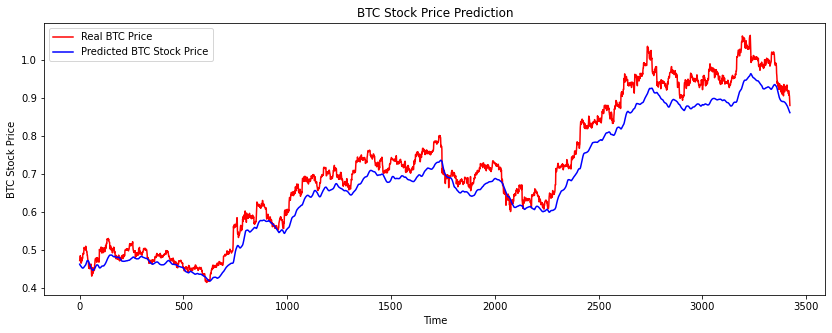

In [11]:
plt.figure(figsize=(14,5))
plt.plot(y_test, color='red', label='Real BTC Price')
plt.plot(y_pred, color='blue', label='Predicted BTC Stock Price')
plt.title('BTC Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Stock Price')
plt.legend()
plt.show()

In [12]:
model.evaluate(x_test, y_test)

107/107 [==============================] - 7s 56ms/step - loss: 0.0024


0.0023761147167533636